In [1]:
## import libraries
import pandas as pd
import numpy as np
import re
import difflib
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import plotly.express as px
from lightgbm import LGBMRegressor
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
from tqdm import tqdm

### WO file correction -- 2023

In [ ]:
## correction of WO/ reactive file 2023

dfr = pd.read_excel("/Users/yashvardhansingh/Desktop/Valiance/cocacola/phase_2/By Dispenser Aggs/2023 reactive service FS9X.xlsx")
column_name_change = {'part_id':'date','platform2':'Platform','priloc':'Issue_desc','Serial Number':'serial_num','customer_name__c':'Chain_Name__c'}
dfr = dfr.rename(columns=column_name_change)
dfi = pd.read_excel("/Users/yashvardhansingh/Desktop/Valiance/cocacola/phase_2/DECAF Install Base v3.xlsx")
column_name_change = {'acn':'outletacn','FS_Serial_Number__c':'serial_num'}
dfi = dfi.rename(columns=column_name_change)

In [ ]:
## variables
date = 'date'
wo_num = 'workordernumber'
outlet_num = 'outletacn'
platform = 'Platform'
cost = 'invoice_total__c'
issue = 'Issue_desc'
serial_num = 'serial_num'
city = 'Outlet_City__c'
state = 'Outlet_State_Province__c'
country = 'Outlet_Country__c'
chain_name = 'Chain_Name__c'
channel = 'trade_channel'
install_date = 'DECAF Install Date'
removal_date = 'DECAF Removal Date'

In [ ]:
level = [date,wo_num,platform,outlet_num,serial_num,cost,issue]
dfr = dfr[level].reset_index(drop=True)
dfi = dfi[~dfi[serial_num].isna()].reset_index(drop=True)

In [ ]:
## percentage of serial number found in install base
found = dfr[dfr[serial_num].isin(dfi[serial_num].unique())][serial_num].nunique()
total = dfr[serial_num].nunique()
print('Correct serial in unique terms %: {}'.format(round(found/total,2)))

In [ ]:
## do basic correction in serial numbers
dfr[serial_num] = dfr[serial_num].apply(lambda x: re.sub(r'\W+', '', x).upper()if pd.notna(x) else x)

In [ ]:
## date correction
dfr[date] = pd.to_datetime(dfr[date], format='%Y%m%d')
fill_date = pd.to_datetime('2150-1-1')
dfi[removal_date].fillna(fill_date,inplace=True)

In [ ]:
def close_match(df,dfi = dfi):
    serial = df[serial_num].iloc[0]
    outlet_no = df[outlet_num].iloc[0]
    platform_no = df[platform].iloc[0]
    date_no = df[date].iloc[0]
    new_serials = dfi[(dfi[outlet_num]==outlet_no)&(dfi[platform]==platform_no)&(dfi[install_date]<date_no)&(dfi[removal_date]>date_no)][serial_num].unique().tolist()
    approx_serial = dfi[(dfi[serial_num]==serial)&(dfi[install_date]<date_no)&(dfi[removal_date]>date_no)][serial_num].unique().tolist()

    ## take care of cases where serial number is correct but outlet or platform is not
    if pd.isna(serial) and not new_serials:
        df['closest_match'] = None
        df['reason'] = 'no valid serial_num in both the sheets'
        return df
    elif not new_serials:
        if not pd.isna(serial) and approx_serial:
            df['closest_match'] = approx_serial[0]
            df['reason'] = 'Found exact match'
            return df
        else:
            df['closest_match'] = None
            df['reason'] = 'no valid serial_num in the Base Sheet'
            return df
    elif pd.isna(serial) and len(new_serials)>=1:
        df['closest_match'] = new_serials[0]
        df['reason'] = 'no valid serial_num in the WO Sheet but found in Base Sheet'
        return df
    elif not pd.isna(serial) and  len(new_serials)==1:
        if serial == new_serials[0]:
            df['closest_match'] = new_serials[0]
            df['reason'] = 'Found exact match'
            return df
        else:
            df['closest_match'] = new_serials[0]
            df['reason'] = 'Not exact match but only one in Base Sheet'
            return df
    elif not pd.isna(serial) and  len(new_serials)>1:
        if serial in new_serials:
            df['closest_match'] = serial
            df['reason'] = 'Found exact match'
            return df
        elif approx_serial:
            df['closest_match'] = serial
            df['reason'] = 'Found exact match'
            return df
        else:
            matches = difflib.get_close_matches(serial, new_serials)
            if matches:
                df['closest_match'] = matches[0]
                df['reason'] = 'Found a Close Match from many serial nos in Base Sheet'
                return df
            else:
                df['closest_match'] = new_serials[0]
                df['reason'] = 'Found a random Match from many serial nos in Base Sheet'
                return df
    else:
        df['closest_match'] = None
        df['reason'] = 'No Usecase'
        return df

In [ ]:
results = dfr.groupby([wo_num],dropna=False).apply(close_match).reset_index(drop=True)

In [ ]:
results.to_excel("WO_sheet_modified_2023.xlsx",index=False)

### WO file correction -- 2022

In [ ]:
## correction of WO/ reactive file 2023

dfr = pd.read_excel("/Users/yashvardhansingh/Desktop/Valiance/cocacola/phase_2/2022 - By Dispenser aggs/2022 Reactive service - By Dispenser.xlsx")
column_name_change = {'part_id':'date','platform2':'Platform','priloc':'Issue_desc','Serial Number':'serial_num','customer_name__c':'Chain_Name__c'}
dfr = dfr.rename(columns=column_name_change)
dfi = pd.read_excel("/Users/yashvardhansingh/Desktop/Valiance/cocacola/phase_2/DECAF Install Base v3.xlsx")
column_name_change = {'acn':'outletacn','FS_Serial_Number__c':'serial_num'}
dfi = dfi.rename(columns=column_name_change)

In [ ]:
## variables
date = 'date'
wo_num = 'workordernumber'
outlet_num = 'outletacn'
platform = 'Platform'
cost = 'invoice_total__c'
issue = 'Issue_desc'
serial_num = 'serial_num'
city = 'Outlet_City__c'
state = 'Outlet_State_Province__c'
country = 'Outlet_Country__c'
chain_name = 'Chain_Name__c'
channel = 'trade_channel'
install_date = 'DECAF Install Date'
removal_date = 'DECAF Removal Date'

In [ ]:
level = [date,wo_num,platform,outlet_num,serial_num,cost,issue]
dfr = dfr[level].reset_index(drop=True)
dfr[serial_num] = dfr[serial_num].astype(str)
dfi = dfi[~dfi[serial_num].isna()].reset_index(drop=True)

In [ ]:
## percentage of serial number found in install base
found = dfr[dfr[serial_num].isin(dfi[serial_num].unique())][serial_num].nunique()
total = dfr[serial_num].nunique()
print('Correct serial in unique terms %: {}'.format(round(found/total,2)))

- initial -- 0.59
- after standardization --- 0.77

In [ ]:
## do basic correction in serial numbers
dfr[serial_num] = dfr[serial_num].apply(lambda x: re.sub(r'\W+', '', x).upper()if pd.notna(x) else x)

In [ ]:
## date correction
dfr[date] = pd.to_datetime(dfr[date], format='%Y%m%d')
fill_date = pd.to_datetime('2150-1-1')
dfi[removal_date].fillna(fill_date,inplace=True)

In [ ]:
def close_match(df,dfi = dfi):
    serial = df[serial_num].iloc[0]
    outlet_no = df[outlet_num].iloc[0]
    platform_no = df[platform].iloc[0]
    date_no = df[date].iloc[0]
    new_serials = dfi[(dfi[outlet_num]==outlet_no)&(dfi[platform]==platform_no)&(dfi[install_date]<date_no)&(dfi[removal_date]>date_no)][serial_num].unique().tolist()
    approx_serial = dfi[(dfi[serial_num]==serial)&(dfi[install_date]<date_no)&(dfi[removal_date]>date_no)][serial_num].unique().tolist()

    ## take care of cases where serial number is correct but outlet or platform is not
    if pd.isna(serial) and not new_serials:
        df['closest_match'] = None
        df['reason'] = 'no valid serial_num in both the sheets'
        return df
    elif not new_serials:
        if not pd.isna(serial) and approx_serial:
            df['closest_match'] = approx_serial[0]
            df['reason'] = 'Found exact match'
            return df
        else:
            df['closest_match'] = None
            df['reason'] = 'no valid serial_num in the Base Sheet'
            return df
    elif pd.isna(serial) and len(new_serials)>=1:
        df['closest_match'] = new_serials[0]
        df['reason'] = 'no valid serial_num in the WO Sheet but found in Base Sheet'
        return df
    elif not pd.isna(serial) and  len(new_serials)==1:
        if serial == new_serials[0]:
            df['closest_match'] = new_serials[0]
            df['reason'] = 'Found exact match'
            return df
        else:
            df['closest_match'] = new_serials[0]
            df['reason'] = 'Not exact match but only one in Base Sheet'
            return df
    elif not pd.isna(serial) and  len(new_serials)>1:
        if serial in new_serials:
            df['closest_match'] = serial
            df['reason'] = 'Found exact match'
            return df
        elif approx_serial:
            df['closest_match'] = serial
            df['reason'] = 'Found exact match'
            return df
        else:
            matches = difflib.get_close_matches(serial, new_serials)
            if matches:
                df['closest_match'] = matches[0]
                df['reason'] = 'Found a Close Match from many serial nos in Base Sheet'
                return df
            else:
                df['closest_match'] = new_serials[0]
                df['reason'] = 'Found a random Match from many serial nos in Base Sheet'
                return df
    else:
        df['closest_match'] = None
        df['reason'] = 'No Usecase'
        return df

In [ ]:
results = dfr.groupby([wo_num],dropna=False).apply(close_match).reset_index(drop=True)

In [ ]:
results.to_excel("WO_sheet_modified_2022.xlsx",index=False)

### MODEL - 1

In [ ]:
df = pd.read_excel("WO_sheet_modified_2023.xlsx")
## variables
date = 'date'
wo_num = 'workordernumber'
outlet_num = 'outletacn'
platform = 'Platform'
cost = 'invoice_total__c'
issue = 'Issue_desc'
serial_num = 'serial_num'
city = 'Outlet_City__c'
state = 'Outlet_State_Province__c'
country = 'Outlet_Country__c'
chain_name = 'Chain_Name__c'
channel = 'trade_channel'
install_date = 'DECAF Install Date'
removal_date = 'DECAF Removal Date'

dfi = pd.read_excel("/Users/yashvardhansingh/Desktop/Valiance/cocacola/phase_2/DECAF Install Base v3.xlsx")
column_name_change = {'acn':'outletacn','FS_Serial_Number__c':'serial_num'}
dfi = dfi.rename(columns=column_name_change)

In [ ]:
cols = [date,wo_num,platform,outlet_num,cost,'closest_match']
df = df[cols].drop_duplicates().reset_index(drop=True).rename(columns={'closest_match':serial_num})
df = df.dropna(subset=[serial_num])
df = df[df[cost]>0].reset_index(drop=True)  ## cost to be more than zero

In [ ]:
df = df.merge(dfi[[serial_num,outlet_num,channel,install_date,city,chain_name,state]].drop_duplicates(),on=[serial_num,outlet_num],how='left')
## multiple outlets with same serial num, install date and channel empty for many
df= df.dropna()

In [ ]:
# Calculate the difference in months
df['age'] = (df[date].dt.to_period('M') - 
                     df[install_date].dt.to_period('M')).apply(lambda x: x.n)
df = df[df['age']>=0].reset_index(drop=True)   ### remove negative ages

In [ ]:
## need to combine some channel with very less data
channel_count = df.groupby(channel)[wo_num].count().reset_index()
channel_count['new_channel'] = np.where(channel_count[wo_num]<=30,'All Other',channel_count[channel])

df = df.merge(channel_count[[channel,'new_channel']].drop_duplicates(),on=channel,how='left')

In [ ]:
## create a month feature
df['month'] = df[date].dt.month

In [ ]:
## months since last service
# Sort the dataframe by 'id' and 'date'
df = df.sort_values([serial_num, date]).reset_index(drop=True)

# Create a new column 'months_since_last_service'
# Calculate months since last service
df['months_since_last_service'] = df.groupby(serial_num)[date].diff().dt.days / 30
df['months_since_last_service'] = df['months_since_last_service'].fillna(0)

In [ ]:
## get volume information for a dipenser
## get avg volume in the month of repair or the last 30 days etc
volume = 'total_vol_ml'
dfv = pd.read_parquet("volume_2023.parquet")
dfv = dfv.rename(columns={'part_id':date,'serial_number':serial_num})
dfv[date] = pd.to_datetime(dfv[date], format='%Y%m%d')

dfv['month'] = dfv[date].dt.month
dfv['avg_mon_volume'] = dfv.groupby([serial_num,'month'])[volume].transform('mean')

df = df.merge(dfv[[serial_num,'month','avg_mon_volume']].drop_duplicates(),on=['month',serial_num],how='left')

df= df.dropna()  ## drop rows where volume is not known

df['avg_volume_standardized'] = (df['avg_mon_volume'] - df['avg_mon_volume'].mean()) / df['avg_mon_volume'].std()

In [ ]:
dff = df[df[platform]==9100].reset_index(drop=True)

### Random forest

In [ ]:
# Encode categorical variables
categorical_cols = ['new_channel', platform]
X[categorical_cols] = X[categorical_cols].astype(str)
numerical_cols = ['age']

In [ ]:
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('scaler', StandardScaler(), numerical_cols)
    ])

# Preprocess the input data
X = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rf = RandomForestRegressor(random_state=42)

# Create a RFECV object to select features
#selector = RFECV(estimator=rf, step=1, cv=7, scoring='neg_mean_squared_error')

# Create a pipeline that first selects features then fits the Random Forest model
pipeline = Pipeline(steps=[('Random Forest', rf)])

# Define a grid of parameters to search over
param_grid = {
    'Random Forest__n_estimators': [50,80],
    'Random Forest__max_depth': [4,5,6,7],
    'Random Forest__min_samples_leaf': [20,30,50]
}

# Use GridSearchCV to search the grid of parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=7, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameter set
print('Best parameters found:\n', grid_search.best_params_)


# Predict and evaluate the model
predictions = grid_search.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Calculating the RMSE
r2 = r2_score(y_test, predictions)
print(f"Root Mean Squared Error: {rmse}")
print(f'R-squared score: {r2}')

In [ ]:
df[cost].mean()

In [ ]:
df[cost].std()

In [ ]:
sns.histplot(data= df,x=cost)

In [ ]:
# Extract the fitted Random Forest model from the grid search
fitted_rf = grid_search.best_estimator_.named_steps['Random Forest']

# Get the feature importances
importances = fitted_rf.feature_importances_

# Get the names of the selected features
def remove_prefix(string_list):
    return [s[9:] if s.startswith("encoder_") else s for s in string_list]

selected_features = remove_prefix(preprocessor.get_feature_names_out())

# Create a DataFrame for plotting
feature_importances_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Create the plot
fig = px.bar(feature_importances_df, x='Importance', y='Feature', orientation='h',
             title='Feature Importance',text_auto=True,text='Importance')
fig.update_layout(width=1000, height=700,title_font_size=24,title=dict(x=0.5, xanchor='center'))
fig.update_traces(texttemplate='%{text:.2f}') # Custom formatting for the text

# Show the plot
fig.show()

# fig.write_image("FI_FS9100.png", scale=3)

- add volume/VPD


### Using LGBM

In [ ]:
# Separate input features and target variable
X = dff[[platform, 'age',city,chain_name,'month','months_since_last_service','avg_volume_standardized']].copy()
X[[platform,city,chain_name]] = X[[platform,city,chain_name]].astype(str)
y = dff[cost].copy()

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# rename cols
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val = X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cat_features=X_train.dtypes[X_train.dtypes == 'object'].index.to_list()
for c in cat_features:
    X_train[c] = X_train[c].astype('category')
    X_val[c] = X_val[c].astype('category')
    X_test[c] = X_test[c].astype('category')

# Create LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = cat_features)
lgb_valid = lgb.Dataset(X_val, y_val, categorical_feature = cat_features,reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, categorical_feature = cat_features)

params = {
    "n_jobs" : 4,
    'min_data_in_leaf':20,
    'learning_rate': 0.03, #0.05 0.02
    'num_iterations' : 1000, 
    'num_leaves' : 30,
    'max_bins':1000
}

model = lgb.train(params,lgb_train,categorical_feature = cat_features,valid_sets=[lgb_train,lgb_valid],callbacks=[early_stopping(10), log_evaluation(10)])


# Predict and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Calculating the RMSE
r2 = r2_score(y_test, predictions)
print(f"Root Mean Squared Error: {rmse}")
print(f'R-squared score: {r2}')

In [ ]:
lgb.plot_importance(model,height = 0.5,dpi=200,figsize=(15,10),importance_type='gain',title=f'Feature importance-9100')

Things to try:
- Volume - done
- Month of Servicing -  done 
- months from last service - done
- add 2022 Data

### LGBM - classification

In [ ]:
# Bucketing the cost into categories (example using quartiles)
dff['cost_category'] = pd.qcut(dff[cost], q=4, labels=False)

X = dff[[platform, 'age',city,chain_name,'month','months_since_last_service','avg_volume_standardized']].copy()
X[[platform,city,chain_name]] = X[[platform,city,chain_name]].astype(str)
y = dff['cost_category'].copy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Rename columns
X_train = X_train.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_val = X_val.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Convert categorical features
cat_features=X_train.dtypes[X_train.dtypes == 'object'].index.to_list()
for c in cat_features:
    X_train[c] = X_train[c].astype('category')
    X_val[c] = X_val[c].astype('category')
    X_test[c] = X_test[c].astype('category')

# Create LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = cat_features)
lgb_valid = lgb.Dataset(X_val, y_val, categorical_feature = cat_features,reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, categorical_feature = cat_features)

# Adjust parameters for classification
params = {
    "objective": "multiclass",
    "num_class": len(y.unique()),
    "n_jobs": 4,
    "learning_rate": 0.03,
    "num_iterations": 1000,
    "num_leaves": 30,
    "min_data_in_leaf":50,
    
}

model = lgb.train(params, lgb_train,categorical_feature = cat_features,valid_sets=[lgb_train, lgb_valid],
                  callbacks=[early_stopping(10), log_evaluation(10)])

# Predict and evaluate
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)  # Get the predicted categories
accuracy = accuracy_score(y_test, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

In [ ]:
lgb.plot_importance(model,height = 0.5,dpi=200,figsize=(15,10),importance_type='gain',title=f'Feature importance-9000')

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Convert the confusion matrix into a DataFrame
cm_df = pd.DataFrame(cm, index=[f'Actual {i}' for i in range(len(cm))], columns=[f'Predicted {i}' for i in range(len(cm))])

cost_ranges = ["Low", "Medium", "High", "Very High"]

# Create a heatmap with Plotly Express
fig = px.imshow(cm_df,
                labels=dict(x="Predicted Label", y="Actual Label", color="Count"),
                x=cost_ranges,
                y=cost_ranges,
                text_auto=True,title="Confusion_Matrix_9000")
fig.update_xaxes(side="top")
fig.show()

### LGMB - Classification on yearly cost

In [ ]:
parts_replaced = 'fru_removal'
# Read the first sheet into a DataFrame
sheet1 = pd.read_excel('By Dispenser Aggs/2023 Parts Replacement - By Dispenser.xlsx', sheet_name='US 9000')
# Read the second sheet into another DataFrame
sheet2 = pd.read_excel('By Dispenser Aggs/2023 Parts Replacement - By Dispenser.xlsx', sheet_name='US 9100')
# Concatenate the two DataFrames
dfparts = pd.concat([sheet1, sheet2], ignore_index=True)

dfparts = dfparts.rename(columns={'serial_number':serial_num})

dfparts = dfparts.groupby(serial_num)[parts_replaced].sum().reset_index()

In [ ]:
dftadd = pd.read_parquet('troubleadd.parquet')
dftadd = dftadd.rename(columns={'serial_number':serial_num})
trouble_count = 'troubleadd_count'
dftadd = dftadd.groupby(serial_num)[trouble_count].sum().reset_index()

In [ ]:
dff = df.groupby([platform,outlet_num,serial_num,city,chain_name,state,'new_channel'])[cost].sum().reset_index()
dff = dff[dff[platform]==9000].reset_index(drop=True)

In [ ]:
dff = dff.merge(dfparts,on=serial_num,how='left').fillna(0)
dff = dff.merge(dftadd,on=serial_num,how='left').fillna(0)

In [ ]:
# Bucketing the cost into categories (example using quartiles)
dff['cost_category'] = pd.qcut(dff[cost], q= 4, labels=False)

X = dff[[platform,city,chain_name,state,parts_replaced,trouble_count]].copy()  #,parts_replaced,trouble_count
X[[platform,city,chain_name,state]] = X[[platform,city,chain_name,state]].astype(str)
y = dff['cost_category'].copy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Rename columns
X_train = X_train.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_val = X_val.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Convert categorical features
cat_features=X_train.dtypes[X_train.dtypes == 'object'].index.to_list()
for c in cat_features:
    X_train[c] = X_train[c].astype('category')
    X_val[c] = X_val[c].astype('category')
    X_test[c] = X_test[c].astype('category')

# Create LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = cat_features)
lgb_valid = lgb.Dataset(X_val, y_val, categorical_feature = cat_features,reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, categorical_feature = cat_features)

# Adjust parameters for classification
params = {
    "objective": "multiclass",
    "num_class": len(y.unique()),
    "n_jobs": 4,
    "learning_rate": 0.03,
    "num_iterations": 1000,
    "num_leaves": 30,
    "min_data_in_leaf":50,
    
}

model = lgb.train(params, lgb_train,categorical_feature = cat_features,valid_sets=[lgb_train, lgb_valid],
                  callbacks=[early_stopping(10), log_evaluation(10)])

# Predict and evaluate
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)  # Get the predicted categories
accuracy = accuracy_score(y_test, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

In [ ]:
tt = dff.groupby('cost_category')[cost].agg(['min', 'max'])

In [ ]:
lgb.plot_importance(model,height = 0.5,dpi=200,figsize=(15,10),importance_type='gain',title=f'Feature importance-9000')

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Convert the confusion matrix into a DataFrame
cm_df = pd.DataFrame(cm, index=[f'Actual {i}' for i in range(len(cm))], columns=[f'Predicted {i}' for i in range(len(cm))])

cost_ranges = ["Low", "Medium", "High","Very High"]  # , "Very High"

# Create a heatmap with Plotly Express
fig = px.imshow(cm_df,
                labels=dict(x="Predicted Label", y="Actual Label", color="Count"),
                x=cost_ranges,
                y=cost_ranges,
                text_auto=True,title="Confusion_Matrix_9000")
fig.update_xaxes(side="top")
fig.show()

things to do
- 9100, 9000 separately
- city ka cluster on (avg price/portfolio avg cost) 
- issue desc

- parts replacement data
- move to sensor data in model 2 

### MODEL - 2

In [2]:
## Read and process data
excel_paths = ['WO_sheet_modified_2022.xlsx',"WO_sheet_modified_2023.xlsx"]
df = pd.concat(
    [pd.read_excel(path) for path in excel_paths],
    ignore_index=True
)

df = df[df['reason'].isin(['Not exact match but only one in Base Sheet', 'Found exact match',
                           'Found a Close Match from many serial nos in Base Sheet'])].reset_index(drop=True)
## variables
date = 'date'
wo_num = 'workordernumber'
outlet_num = 'outletacn'
platform = 'Platform'
cost = 'invoice_total__c'
issue = 'Issue_desc'
serial_num = 'serial_num'
city = 'Outlet_City__c'
state = 'Outlet_State_Province__c'
country = 'Outlet_Country__c'
chain_name = 'Chain_Name__c'
channel = 'trade_channel'
install_date = 'DECAF Install Date'
removal_date = 'DECAF Removal Date'
hours = 'hoursworked__c'

dfi = pd.read_excel("/Users/yashvardhansingh/Desktop/Valiance/cocacola/phase_2/DECAF Install Base v3.xlsx")
column_name_change = {'acn':'outletacn','FS_Serial_Number__c':'serial_num'}
dfi = dfi.rename(columns=column_name_change)

In [3]:
cols = [date,wo_num,platform,outlet_num,cost,'closest_match']
df = df[cols].drop_duplicates().reset_index(drop=True).rename(columns={'closest_match':serial_num})
df = df.dropna(subset=[serial_num])
df = df[df[cost]>0].reset_index(drop=True)  ## cost to be more than zero

In [4]:
df = df.merge(dfi[[serial_num,outlet_num,channel,install_date,city,chain_name,state]].drop_duplicates(),on=[serial_num,outlet_num],how='left')
## multiple outlets with same serial num, install date and channel empty for many
df= df.dropna()

In [5]:
# Calculate the difference in months
df['age'] = (df[date].dt.to_period('M') - 
                     df[install_date].dt.to_period('M')).apply(lambda x: x.n)
df = df[df['age']>=0].reset_index(drop=True)   ### remove negative ages

In [7]:
## need to combine some channel with very less data
channel_count = df.groupby(channel)[wo_num].count().reset_index()
channel_count['new_channel'] = np.where(channel_count[wo_num]<=30,'All Other',channel_count[channel])

df = df.merge(channel_count[[channel,'new_channel']].drop_duplicates(),on=channel,how='left')

In [8]:
## create a month feature
df['month'] = df[date].dt.month

In [9]:
## months since last service
# Sort the dataframe by 'id' and 'date'
df = df.sort_values([serial_num, date]).reset_index(drop=True)

# Create a new column 'months_since_last_service'
# Calculate months since last service
df['months_since_last_service'] = df.groupby(serial_num)[date].diff().dt.days / 30
df['months_since_last_service'] = df['months_since_last_service'].fillna(0)

In [10]:
def get_rolling_features(df,dfeature,feature_col,window_days):
    join_cols = [serial_num,date]
    df = df.sort_values(by=join_cols)
    dfeature = dfeature.sort_values(by=join_cols)

    # Create a full date range for each serial_num in dfv to fill missing dates
    all_dates = dfeature.groupby(serial_num)[date].apply(lambda x: pd.date_range(start=x.min(), end=x.max(), freq='D')).explode().reset_index()
    
    # Merge full date range back into dfv to ensure no missing dates
    dfeature_full = pd.merge(all_dates, dfeature, how='left', left_on=[serial_num, date], right_on=[serial_num, date])

    rolling_col_name = f'{window_days}d_{feature_col}'
    dfeature_full[rolling_col_name] = dfeature_full.groupby(serial_num)[feature_col].transform(lambda x: x.rolling(window=window_days, min_periods=1).mean())

    df = pd.merge(df, dfeature_full[join_cols + [rolling_col_name]], on=join_cols, how='left')

    return df

"""Rolling features"""

volume = 'total_vol_ml'
dfv = pd.read_parquet("volume_2023.parquet")
dfv = dfv.rename(columns={'part_id':date,'serial_number':serial_num})
dfv[date] = pd.to_datetime(dfv[date], format='%Y%m%d')

dftadd = pd.read_parquet('troubleadd.parquet')
dftadd = dftadd.rename(columns={'part_id':date,'serial_number':serial_num})
trouble_count = 'troubleadd_count'


df = get_rolling_features(df,dfv,volume,7)
df = get_rolling_features(df,dftadd,trouble_count,7)

df= df.dropna()  ## drop rows where volume is not known ## 7735 has no volume data
df['avg_volume_standardized'] = (df['avg_mon_volume'] - df['avg_mon_volume'].mean()) / df['avg_mon_volume'].std()

In [22]:
### get rolling features using all the sensor data 
folder_path = '/Users/yashvardhansingh/Desktop/Valiance/cocacola/phase_2/sensor_data'

# Get a list of all Parquet files in the folder
parquet_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.parquet')]

# Loop through each Parquet file
for file_path in tqdm(parquet_files, desc='Processing files', unit='file'):
    try:
        df_feature = pd.read_parquet(file_path)
        df_feature = df_feature.rename(columns={'part_id':date,'serial_number':serial_num})
        df_feature[date] = pd.to_datetime(df_feature[date], format='%Y%m%d')

        feature_name = list(set(df_feature.columns) - set([date,serial_num]))

        df = get_rolling_features(df,df_feature,feature_name[0],7)

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

Processing files:   0%|          | 0/17 [00:00<?, ?file/s]

Processing files: 100%|██████████| 17/17 [09:49<00:00, 34.66s/file]


"""Paths to your Excel files"""
excel_paths = ['2022 - By Dispenser aggs/2022 US 9000 Trouble Add - By Dispenser.xlsx', '2022 - By Dispenser aggs/2022 US 9100 Trouble Add - By Dispenser.xlsx',
               'By Dispenser Aggs/2023 US 9000 TroubleAdd - By Dispenser.xlsx','By Dispenser Aggs/2023 US 9100 TroubleAdd - By Dispenser.xlsx']


combined_df_final = pd.concat(
    [pd.concat(pd.read_excel(path, sheet_name=None).values(), ignore_index=True) for path in excel_paths],
    ignore_index=True
)
combined_df_final.to_parquet("trouble_add.parquet")

In [43]:
df_hours = pd.read_csv('Reactive Service Travel and Labor Times.csv').rename(columns={'part_id':date})
df = df.merge(df_hours[[wo_num,hours]],on=wo_num,how='left')
df = df.dropna(subset=[hours]).reset_index(drop=True)

In [3]:
df = pd.read_parquet('master_df.parquet')

In [22]:
dff = df[df[platform]==9100].reset_index(drop=True)

In [23]:
# Separate input features and target variable
sensor_cols = [col for col in dff.columns if col.startswith('7d')]
X = dff[['age',city,chain_name,state,'month','months_since_last_service',hours]+ sensor_cols].copy()  # hours
X[[city,chain_name,state]] = X[[city,chain_name,state]].astype(str)
y = dff[cost].copy()  # cost

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# rename cols
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val = X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cat_features=X_train.dtypes[X_train.dtypes == 'object'].index.to_list()
for c in cat_features:
    X_train[c] = X_train[c].astype('category')
    X_val[c] = X_val[c].astype('category')
    X_test[c] = X_test[c].astype('category')

# Create LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = cat_features)
lgb_valid = lgb.Dataset(X_val, y_val, categorical_feature = cat_features,reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, categorical_feature = cat_features)

params = {
    "n_jobs" : 4,
    'min_data_in_leaf':20,
    'learning_rate': 0.03, #0.05 0.02
    'num_iterations' : 1000, 
    'num_leaves' : 30
}

model = lgb.train(params,lgb_train,categorical_feature = cat_features,valid_sets=[lgb_train,lgb_valid],callbacks=[early_stopping(10), log_evaluation(10)])


# Predict and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Calculating the RMSE
r2 = r2_score(y_test, predictions)
print(f"Root Mean Squared Error: {rmse}")
print(f'R-squared score: {r2}')

/Users/yashvardhansingh/miniconda3/envs/yashml/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5662
[LightGBM] [Info] Number of data points in the train set: 47968, number of used features: 24
[LightGBM] [Info] Start training from score 247.454568
Training until validation scores don't improve for 10 rounds
[10]	training's l2: 42509.4	valid_1's l2: 42515.6
[20]	training's l2: 33024.1	valid_1's l2: 33279.8
[30]	training's l2: 27704.8	valid_1's l2: 28334.1
[40]	training's l2: 24603.4	valid_1's l2: 25750.9
[50]	training's l2: 22755.9	valid_1's l2: 24368.4
[60]	training's l2: 21589.4	valid_1's l2: 23637.9


<Axes: title={'center': 'Feature importance-9000'}, xlabel='Feature importance', ylabel='Features'>

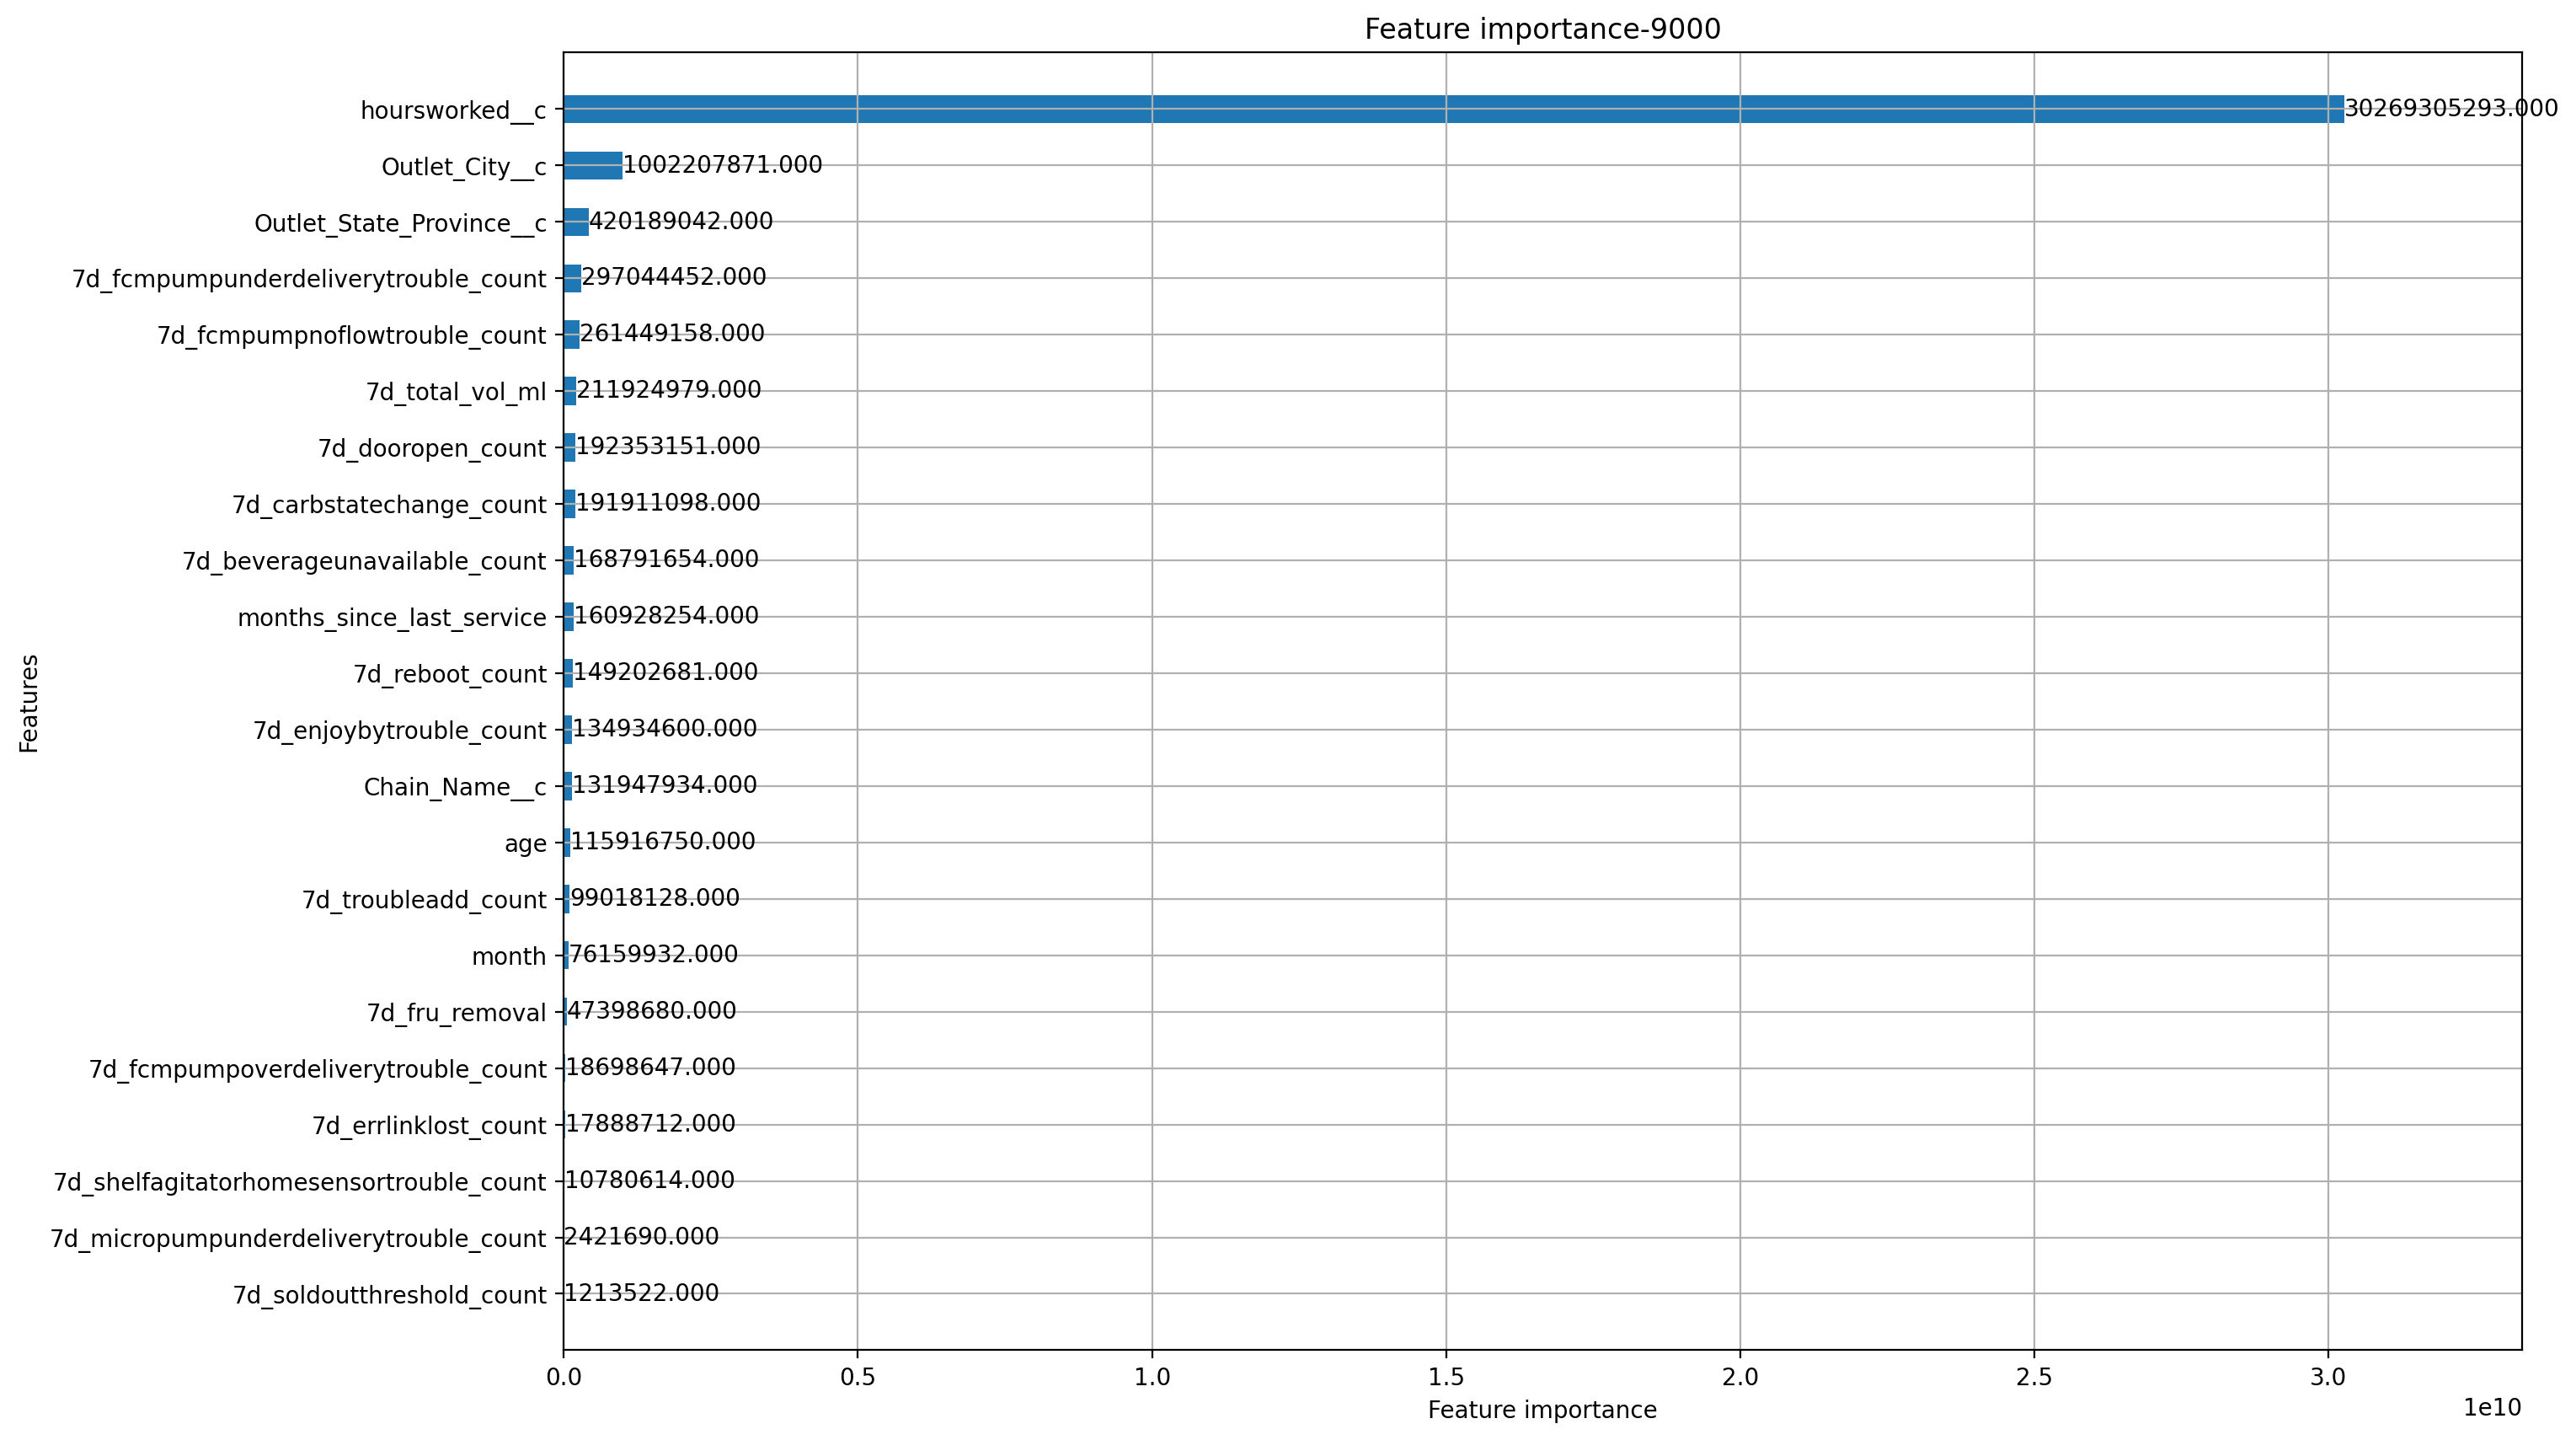

In [24]:
lgb.plot_importance(model,height = 0.5,dpi=200,figsize=(15,10),importance_type='gain',title=f'Feature importance-9000')

In [25]:
# Bucketing the cost into categories (example using quartiles)
dff['cost_category'] = pd.qcut(dff[cost], q=[0,0.3,0.6,1.0], labels=False)

sensor_cols = [col for col in dff.columns if col.startswith('7d')]
X = dff[['age',city,chain_name,state,'month','months_since_last_service',hours]+ sensor_cols].copy()
X[[city,chain_name,state]] = X[[city,chain_name,state]].astype(str)
y = dff['cost_category'].copy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Rename columns
X_train = X_train.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_val = X_val.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Convert categorical features
cat_features=X_train.dtypes[X_train.dtypes == 'object'].index.to_list()
for c in cat_features:
    X_train[c] = X_train[c].astype('category')
    X_val[c] = X_val[c].astype('category')
    X_test[c] = X_test[c].astype('category')

# Create LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = cat_features)
lgb_valid = lgb.Dataset(X_val, y_val, categorical_feature = cat_features,reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, categorical_feature = cat_features)

# Adjust parameters for classification
params = {
    "objective": "multiclass",
    "num_class": len(y.unique()),
    "n_jobs": 4,
    "learning_rate": 0.03,
    "num_iterations": 1000,
    "num_leaves": 30,
    "min_data_in_leaf":50,
    
}

model = lgb.train(params, lgb_train,categorical_feature = cat_features,valid_sets=[lgb_train, lgb_valid],
                  callbacks=[early_stopping(10), log_evaluation(10)])

# Predict and evaluate
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)  # Get the predicted categories
accuracy = accuracy_score(y_test, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

/Users/yashvardhansingh/miniconda3/envs/yashml/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5662
[LightGBM] [Info] Number of data points in the train set: 47968, number of used features: 24
[LightGBM] [Info] Start training from score -1.201225
[LightGBM] [Info] Start training from score -1.207412
[LightGBM] [Info] Start training from score -0.915780
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.953673	valid_1's multi_logloss: 0.962064
[20]	training's multi_logloss: 0.873997	valid_1's multi_logloss: 0.889849
[30]	training's multi_logloss: 0.823263	valid

<Axes: title={'center': 'Feature importance-9000'}, xlabel='Feature importance', ylabel='Features'>

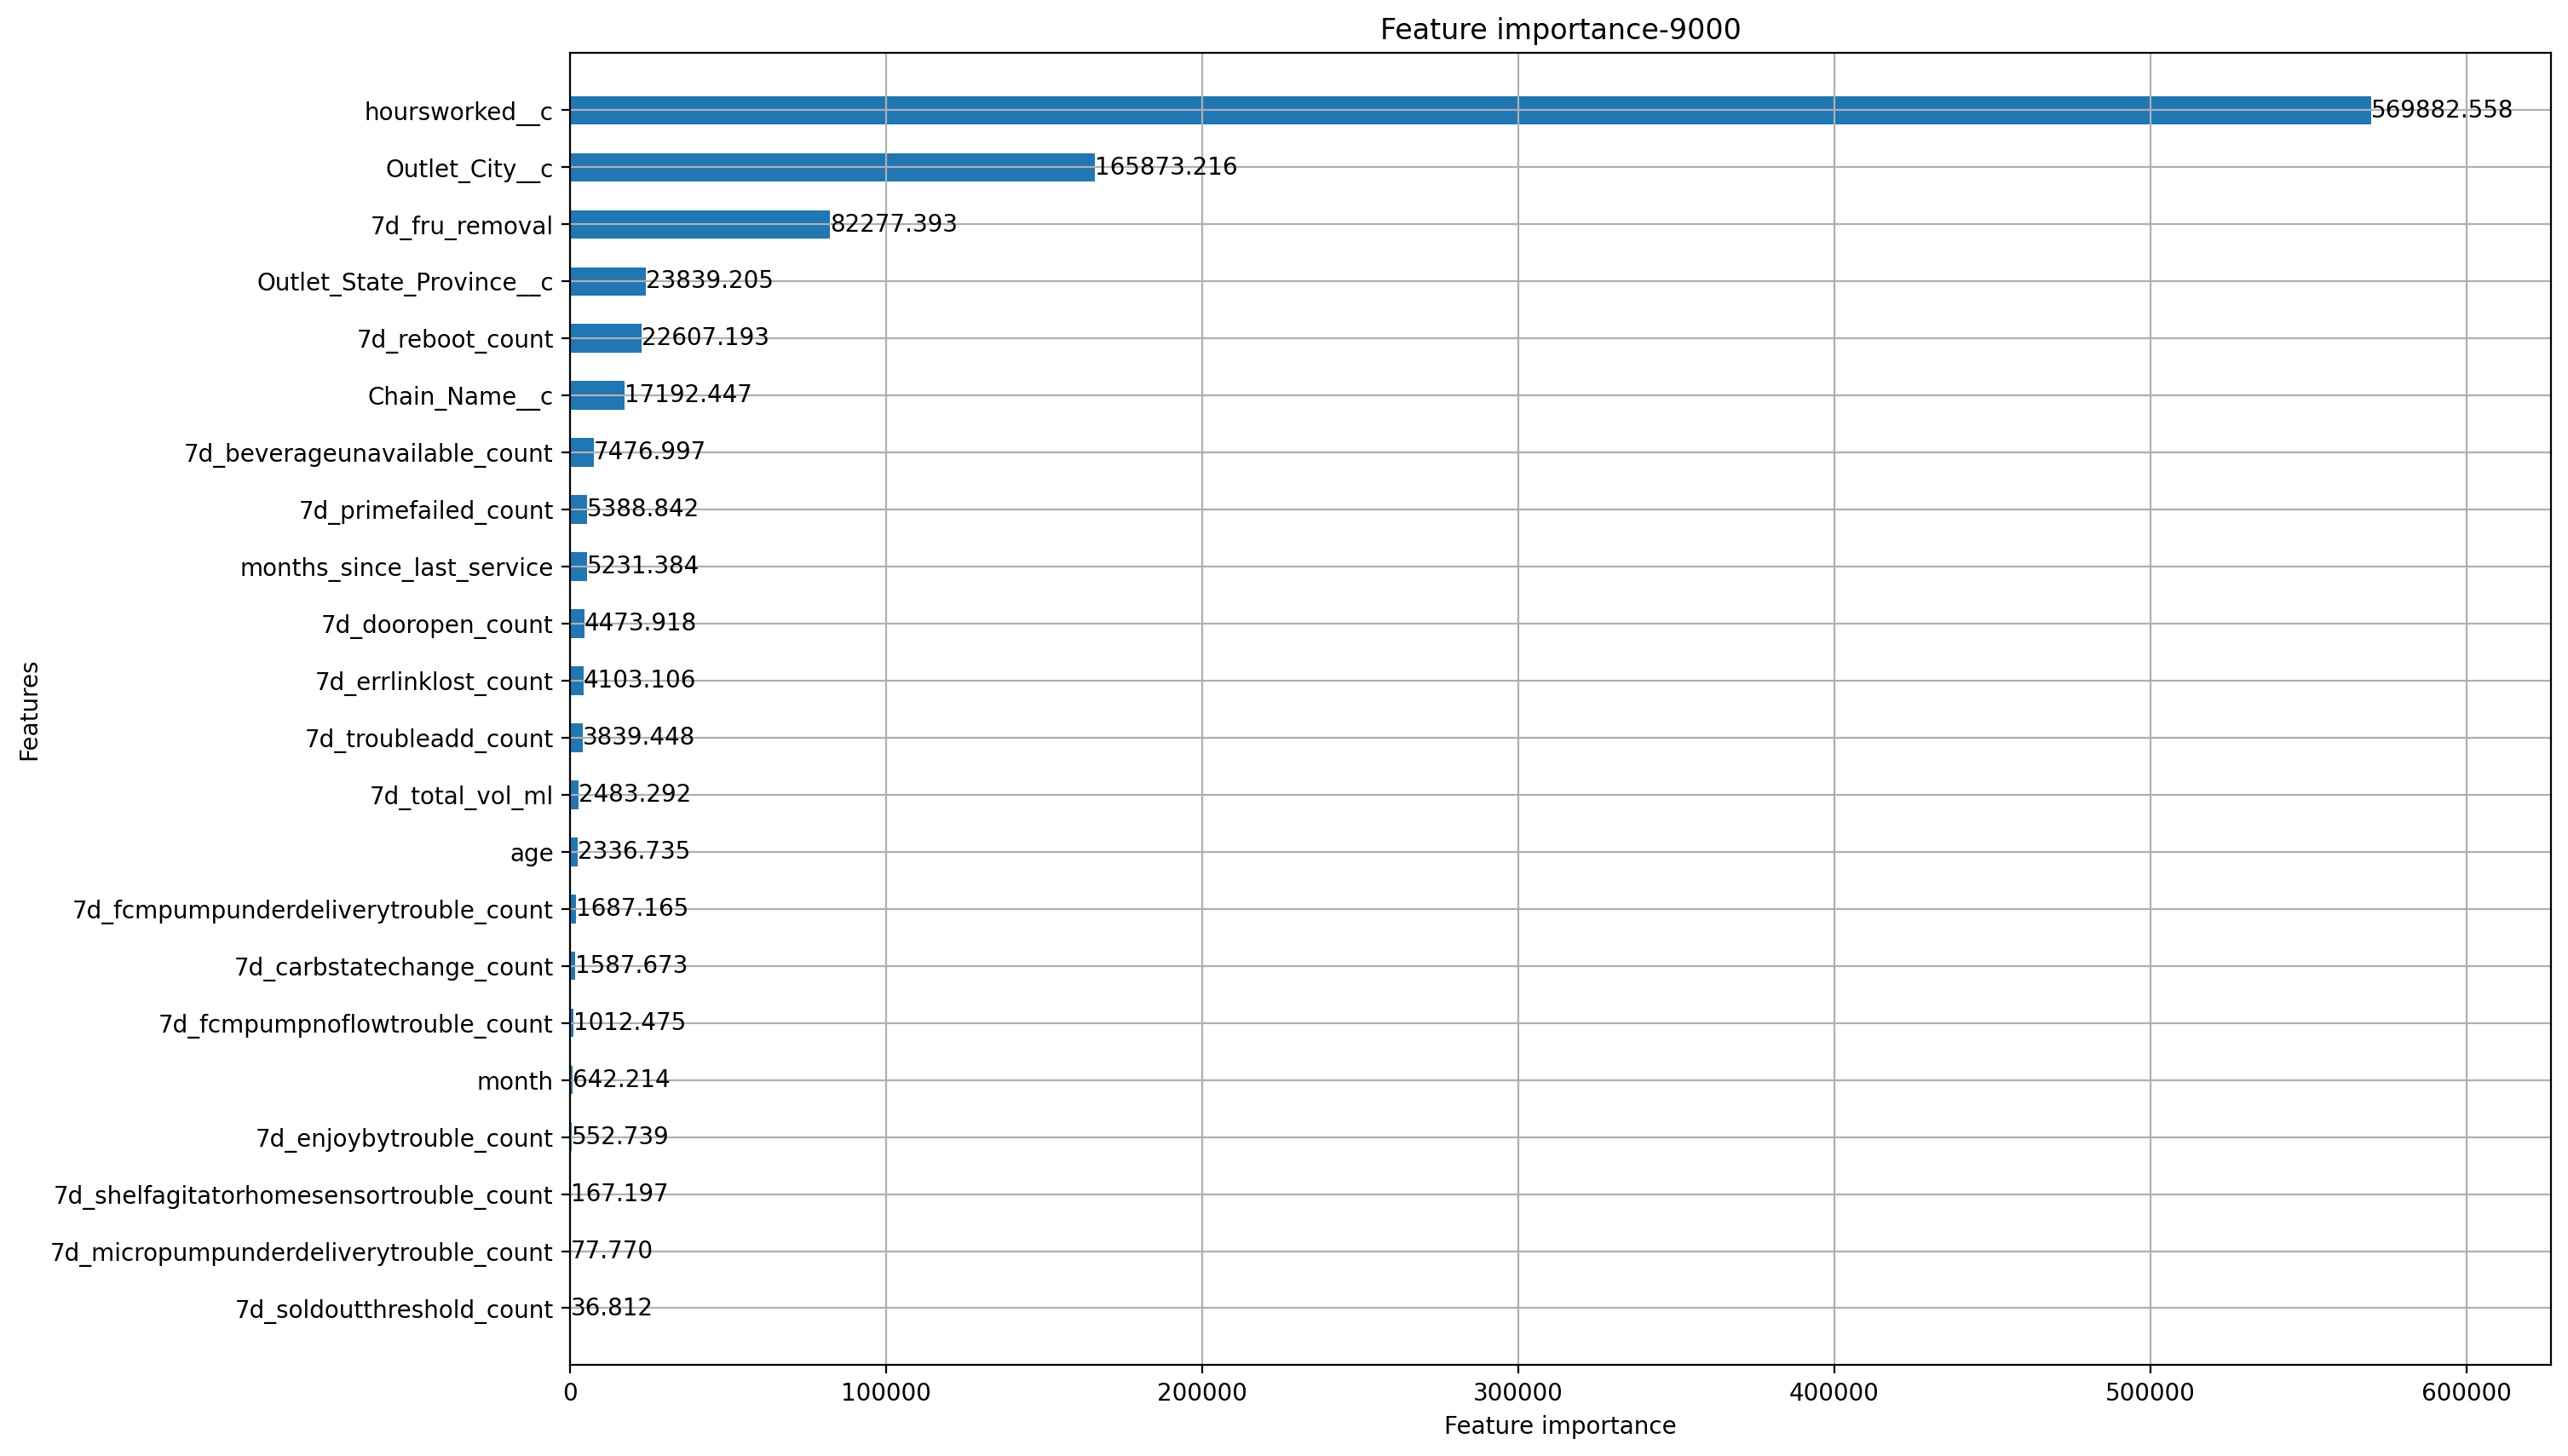

In [20]:
lgb.plot_importance(model,height = 0.5,dpi=200,figsize=(15,10),importance_type='gain',title=f'Feature importance-9000')

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Convert the confusion matrix into a DataFrame
cm_df = pd.DataFrame(cm, index=[f'Actual {i}' for i in range(len(cm))], columns=[f'Predicted {i}' for i in range(len(cm))])

cost_ranges = ["Low", "Medium", "High"] # , "Very High"

# Create a heatmap with Plotly Express
fig = px.imshow(cm_df,
                labels=dict(x="Predicted Label", y="Actual Label", color="Count"),
                x=cost_ranges,
                y=cost_ranges,
                text_auto=True,title="Confusion_Matrix_9100")
fig.update_xaxes(side="top")
fig.show()

TO DO:
- add part replaced flag based on price